In [ ]:
import os
import json
import numpy as np

T = 30   # fixed frames
K = 18   # keypoints
C = 3    # x, y, conf
import numpy as np
import json

def load_json_sample(json_path, T=30, conf_thresh=0.20):

    # -----------------------
    # Load JSON
    # -----------------------
    with open(json_path, "r") as f:
        data = json.load(f)

    # -----------------------
    # Extract raw frames
    # -----------------------
    frames = []
    all_x = []
    all_y = []

    for frame in data:
        kp = []
        for p in frame["keypoints"]:
            x = p["x"]
            y = p["y"]
            c = p["confidence"]

            all_x.append(x)
            all_y.append(y)

            kp.append([x, y, c])
        frames.append(kp)

    frames = np.array(frames)  # shape = (F, 18, 3)

    # -----------------------
    # Normalize XY
    # -----------------------
    max_x = max(all_x)
    max_y = max(all_y)

    frames[:, :, 0] /= max_x
    frames[:, :, 1] /= max_y

    # -----------------------
    # Confidence mask
    # -----------------------
    low_conf = frames[:, :, 2] < conf_thresh
    frames[:, :, 0][low_conf] = 0
    frames[:, :, 1][low_conf] = 0
    frames[:, :, 2][low_conf] = 0

    # -----------------------
    # Uniform temporal sampling
    # -----------------------
    if len(frames) < T:
        # interpolate instead of padding zeros
        idx = np.linspace(0, len(frames)-1, T)
        frames = np.array([frames[int(i)] for i in idx])
    else:
        idx = np.linspace(0, len(frames)-1, T).astype(int)
        frames = frames[idx]

    # -----------------------
    # reshape for 3D CNN
    # -----------------------
    return frames.reshape(T, 18, 3, 1)


In [ ]:
root_json = "/content/KTP-Dataset/dataset-final-json-ready"

X, y = [], []
class_map = {}
cls_id = 0

for cls in sorted(os.listdir(root_json)):
    folder = os.path.join(root_json, cls)
    if not os.path.isdir(folder):
        continue

    class_map[cls] = cls_id

    for file in os.listdir(folder):
        if file.endswith(".json"):
            fpath = os.path.join(folder, file)
            X.append(load_json_sample(fpath))
            y.append(cls_id)

    cls_id += 1

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, y.shape)
print("Class map:", class_map)


Dataset shape: (599, 30, 18, 3, 1) (599,)
Class map: {'boxing': 0, 'handclapping': 1, 'handwaving': 2, 'jogging': 3, 'running': 4, 'walk': 5}


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model


def conv3d_bn(x, filters, k, s):
    x = Conv3D(filters, k, strides=s, padding="same")(x)
    x = BatchNormalization()(x)
    return ReLU()(x)


def res_block(x, filters):
    shortcut = x

    x = conv3d_bn(x, filters, (3,3,3), (1,1,1))
    x = Conv3D(filters, (3,3,3), padding="same")(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv3D(filters, (1,1,1))(shortcut)

    return ReLU()(x + shortcut)


def ResNet18_Skeleton_Dropout(input_shape=(30,18,3,1), num_classes=6, dropout_rate=0.3):
    inp = Input(shape=input_shape)

    # Layer 1
    x = conv3d_bn(inp, 64, (3,3,3), (1,1,1))
    x = res_block(x, 64)
    x = MaxPool3D(pool_size=(1,2,1))(x)  # 18 → 9
    x = Dropout(dropout_rate)(x)

    # Layer 2
    x = res_block(x, 128)
    x = MaxPool3D(pool_size=(1,2,1))(x)  # 9 → 5
    x = Dropout(dropout_rate)(x)

    # Layer 3
    x = res_block(x, 256)
    x = MaxPool3D(pool_size=(1,2,1))(x)  # 5 → 3
    x = Dropout(dropout_rate)(x)

    # Layer 4
    x = res_block(x, 512)
    x = Dropout(dropout_rate)(x)

    x = GlobalAveragePooling3D()(x)

    x = Dropout(dropout_rate)(x)

    out = Dense(num_classes, activation="softmax")(x)

    return Model(inp, out)


In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np

histories = []
fold_accuracies = []
fold_losses = []
fold_confusions = []

fold = 1
for train_idx, test_idx in kf.split(X):

    print(f"\n===== FOLD {fold} =====")

    model = ResNet18_Skeleton_Dropout(
        num_classes=len(class_map),
        dropout_rate=0.3
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    checkpoint_path = f"/content/best_model_fold_{fold}.keras"

    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.3, patience=4),
        ModelCheckpoint(checkpoint_path,
                        monitor='loss',
                        save_best_only=True,
                        verbose=1)
    ]

    # Train (no validation split)
    history = model.fit(
        X[train_idx], y[train_idx],
        epochs=100,
        batch_size=8,
        callbacks=callbacks,
        verbose=1
    )

    histories.append(history)

    # Load the best model
    best_model = tf.keras.models.load_model(checkpoint_path)

    # Evaluate
    test_loss, test_acc = best_model.evaluate(X[test_idx], y[test_idx], verbose=0)

    fold_losses.append(test_loss)
    fold_accuracies.append(test_acc)

    print(f"Fold {fold} accuracy = {test_acc:.4f}")

    # Confusion matrix
    y_pred = np.argmax(best_model.predict(X[test_idx]), axis=1)
    cm = confusion_matrix(y[test_idx], y_pred)
    fold_confusions.append(cm)

    fold += 1



===== FOLD 1 =====
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.3043 - loss: 1.8795
Epoch 1: loss improved from inf to 1.64604, saving model to /content/best_model_fold_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 278ms/step - accuracy: 0.3051 - loss: 1.8757 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4281 - loss: 1.3719
Epoch 2: loss improved from 1.64604 to 1.42357, saving model to /content/best_model_fold_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4278 - loss: 1.3727 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4468 - loss: 1.3043
Epoch 3: loss improved from 1.42357 to 1.20541, saving model to /content/best_model_fold_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.4475 - loss: 1.3027 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4869 - loss: 1.1220
Epoch 4: loss improved from 1.20541 to 1

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 269ms/step - accuracy: 0.3138 - loss: 1.8234 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4442 - loss: 1.3971
Epoch 2: loss improved from 1.63386 to 1.34426, saving model to /content/best_model_fold_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.4442 - loss: 1.3962 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4723 - loss: 1.1689
Epoch 3: loss improved from 1.34426 to 1.13704, saving model to /content/best_model_fold_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.4727 - loss: 1.1684 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5440 - loss: 1.0647
Epoch 4: loss improved from 1.13704 to 1.05159, saving model to /content/best_model_fold_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5442 - loss: 1.0645 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 360ms/step - accuracy: 0.3102 - loss: 2.0921 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4374 - loss: 1.3363
Epoch 2: loss improved from 1.74432 to 1.29888, saving model to /content/best_model_fold_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.4372 - loss: 1.3357 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4887 - loss: 1.1691
Epoch 3: loss improved from 1.29888 to 1.14413, saving model to /content/best_model_fold_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4888 - loss: 1.1686 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4996 - loss: 1.0668
Epoch 4: loss improved from 1.14413 to 1.06148, saving model to /content/best_model_fold_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5000 - loss: 1.0667 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 594ms/step

===== FOLD 4 =====
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.2645 - loss: 1.9753
Epoch 1: loss improved from inf to 1.69511, saving model to /content/best_model_fold_4.keras


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 358ms/step - accuracy: 0.2660 - loss: 1.9707 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4286 - loss: 1.3442
Epoch 2: loss improved from 1.69511 to 1.28082, saving model to /content/best_model_fold_4.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4288 - loss: 1.3432 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4662 - loss: 1.1919
Epoch 3: loss improved from 1.28082 to 1.14560, saving model to /content/best_model_fold_4.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.4666 - loss: 1.1912 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5226 - loss: 1.0774
Epoch 4: loss improved from 1.14560 to 1.09834, saving model to /content/best_model_fold_4.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 450ms/step - accuracy: 0.5227 - loss: 1.0778 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 174ms/step - accuracy: 0.3626 - loss: 1.8364 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4950 - loss: 1.1778
Epoch 2: loss improved from 1.54140 to 1.18740, saving model to /content/best_model_fold_5.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.4949 - loss: 1.1779 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5210 - loss: 1.0892
Epoch 3: loss improved from 1.18740 to 1.11381, saving model to /content/best_model_fold_5.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5209 - loss: 1.0896 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5584 - loss: 1.0343
Epoch 4: loss improved from 1.11381 to 1.05875, saving model to /content/best_model_fold_5.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.5580 - loss: 1.0347 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━

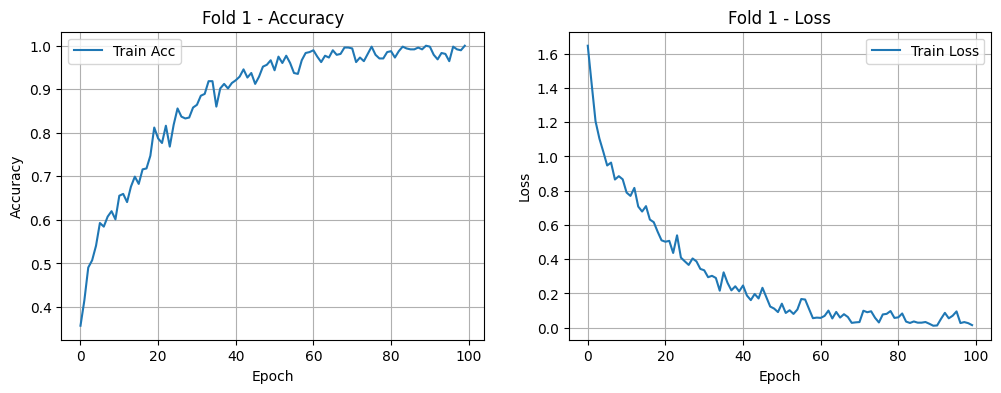

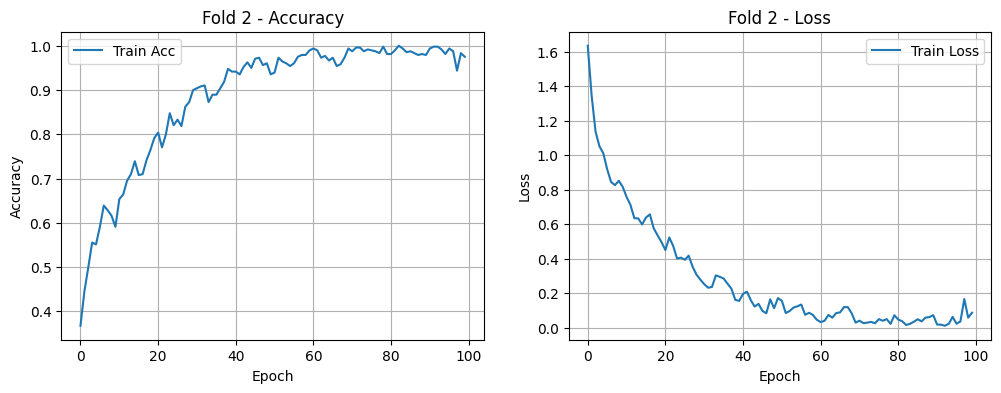

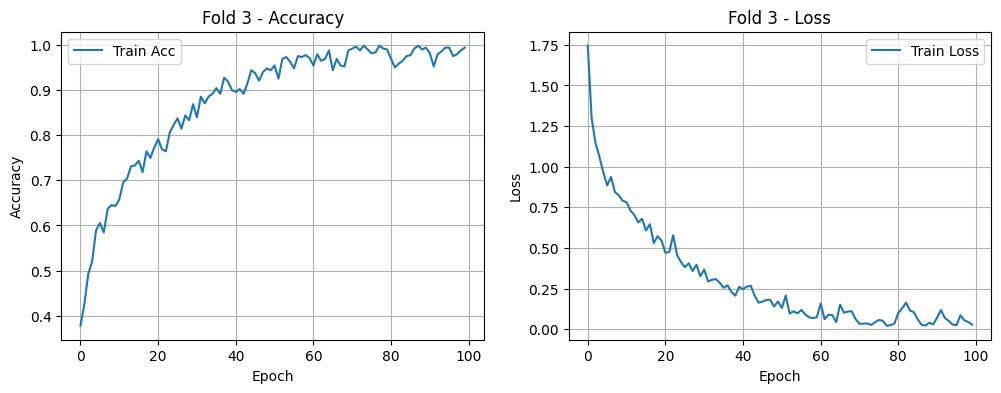

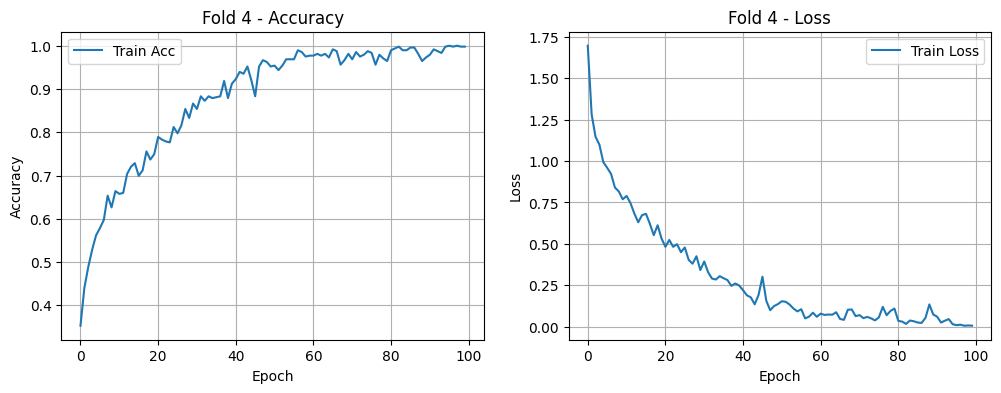

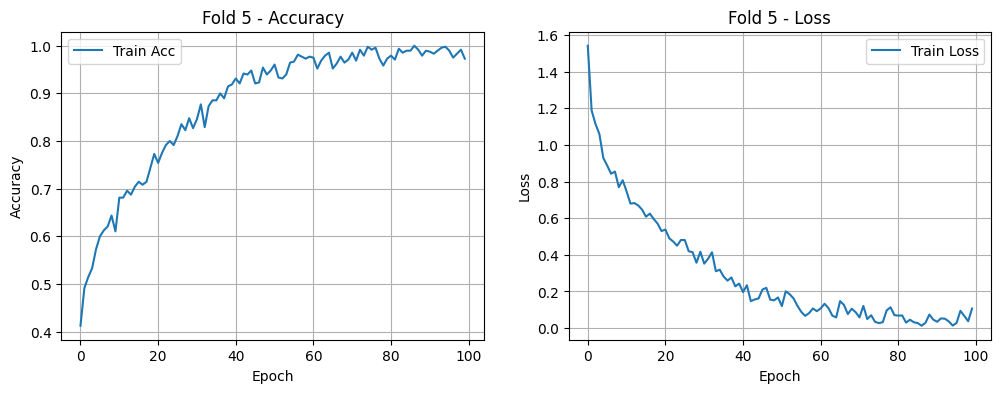

In [ ]:
import matplotlib.pyplot as plt

for i, h in enumerate(histories, start=1):
    plt.figure(figsize=(12,4))

    # --- Accuracy ---
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.title(f"Fold {i} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # --- Loss ---
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='Train Loss')
    plt.title(f"Fold {i} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.show()


In [ ]:
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)

print("====================================")
print("K-Fold Results")
print("====================================")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Std Deviation: {std_acc:.4f}")
print("All Fold Accuracies:", fold_accuracies)


K-Fold Results
Mean Accuracy: 0.8013
Std Deviation: 0.0275
All Fold Accuracies: [0.8500000238418579, 0.800000011920929, 0.7749999761581421, 0.7749999761581421, 0.8067227005958557]


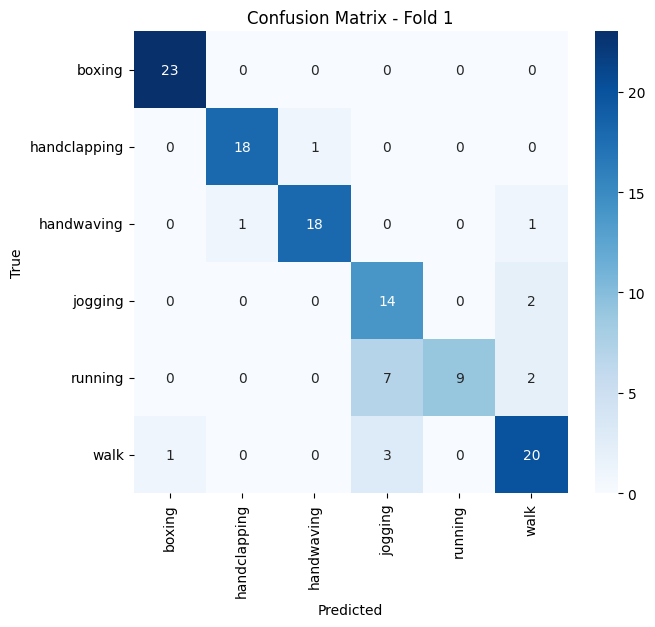

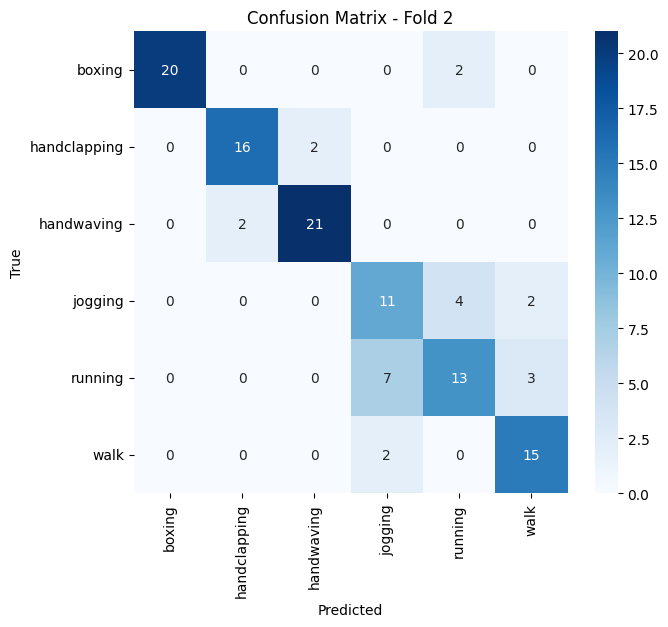

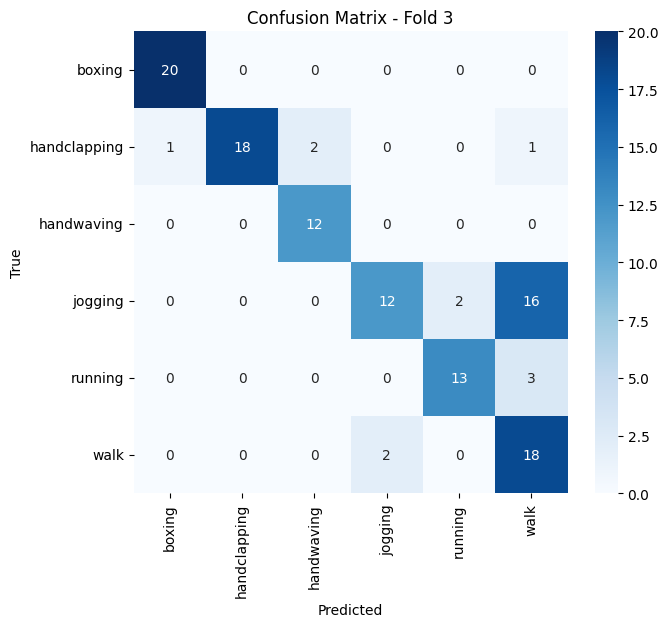

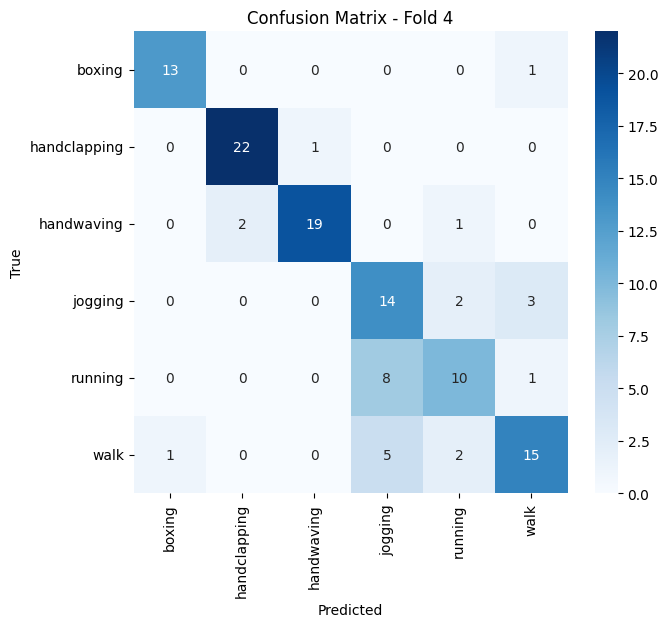

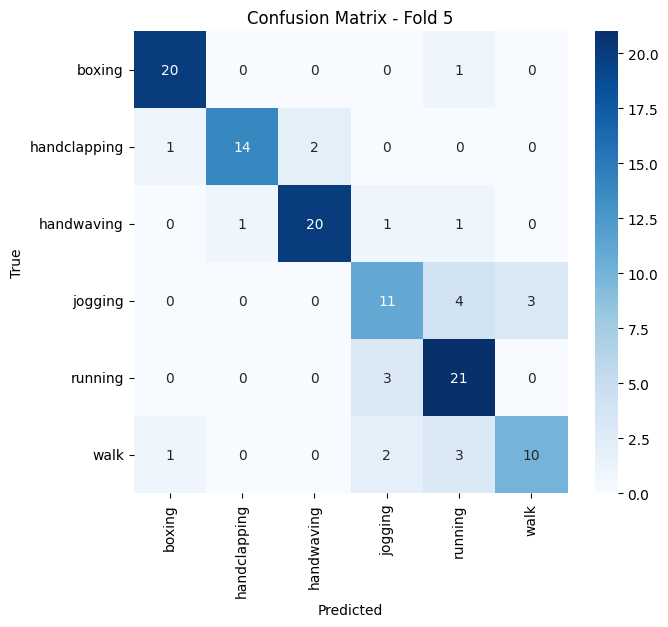

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = list(class_map.keys())   # class names

for i, cm in enumerate(fold_confusions, start=1):
    plt.figure(figsize=(7,6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f"Confusion Matrix - Fold {i}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
print("\nFinal K-Fold Accuracies:", fold_accuracies)
print("Mean Accuracy:", np.mean(fold_accuracies))
print("Std Accuracy:", np.std(fold_accuracies))



Final K-Fold Accuracies: [0.8500000238418579, 0.800000011920929, 0.7749999761581421, 0.7749999761581421, 0.8067227005958557]
Mean Accuracy: 0.8013445377349854
Std Accuracy: 0.02751785079933006
